# Initialize GemPy Model

In [ ]:
import sys
import scipy.stats as ss
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import itertools
from tqdm import tqdm
import warnings
import networkx

# append path to gempy repository and import
# sys.path.append("C:/Users/r02as18/git/gempy/")
import gempy as gp

from copy import deepcopy, copy

sys.path.append("C:/Users/r02as18/git/plothelper/")
import plothelper as ph

In [ ]:
geo_data = gp.create_data([0,2000,0,2000,0,2000],
                          [50,50,50],
                          path_o = "../input_data/simple_fault_model_orientations.csv", # importing orientation (foliation) data
                          path_i = "../input_data/simple_fault_model_points.csv") # importing point-positional interface data

gp.set_series(geo_data, {"Fault_Series":'Main_Fault',
                         "Strat_Series": ('Sandstone_2','Siltstone', 'Shale', 'Sandstone_1')},
                          order_series = ["Fault_Series", 'Strat_Series'],
                          order_formations=['Main_Fault',
                                            'Sandstone_2','Siltstone', 'Shale', 'Sandstone_1'], verbose=0)

In [3]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1,1], output='geology', 
                                  compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  1


In [4]:
# make copy of interp_data data for reset after stochastic modifcations
geo_data_res_stoch = deepcopy(interp_data.geo_data_res)
# define random seed for reproducibility
rseed = 123  

In [9]:
lb_init, fb_init = gp.compute_model(interp_data)
G, C, *_, rprops = gp.topology_compute(geo_data, lb_init[0], fb_init, filter_rogue=True, return_rprops=True, filter_threshold_area=20)

In [10]:
G_observed = pickle.load(open("G_3d.p", "rb"))

C:/Users/r02as18/git/gempy\gempy\gempy_front.py:956: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


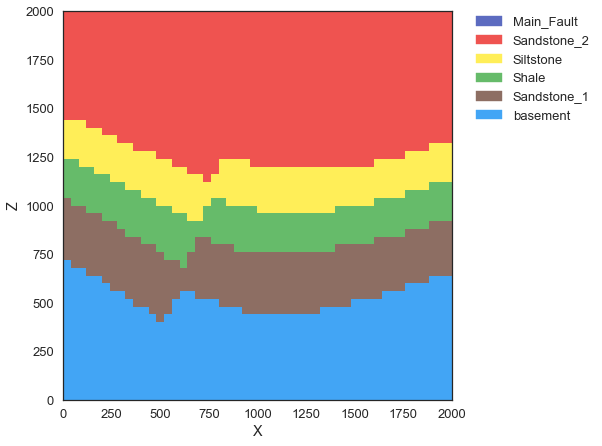

In [11]:
gp.plot_section(geo_data, lb_init[0], 12)

C:/Users/r02as18/git/gempy\gempy\gempy_front.py:956: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


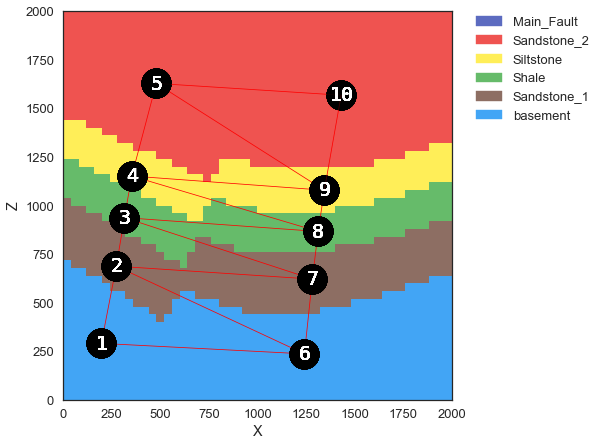

In [15]:
gp.plot_section(geo_data, lb_init[0], 12)
gp.plotting.plot_topology(geo_data, G, C, label_kwargs={"size": 20}, node_kwargs={"markersize": 30}, edge_kwargs={"color": "red"})

In [51]:
from matplotlib import rcParams

rcParams.update(ph.params)

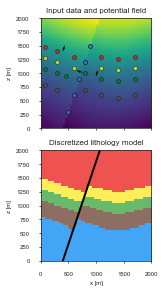

In [75]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=ph.get_figsize(2, textwidth=522/2.))

axes[1].plot(np.array([330,1000])+70,[0,2000], linewidth=2, color="black", alpha=1)
axes[0].imshow(lb_init[1].reshape(*geo_data.resolution)[:,24,:].T, origin="lower", cmap="viridis", extent=[0, 2000, 0, 2000])
axes[1].imshow(lb_init[0].reshape(*geo_data.resolution)[:,24,:].T, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm, extent=[0, 2000, 0, 2000])

for prior, color in zip([prior.name for prior in priors], ["red", "yellow", "green", "#6d4c1a", "#4372bc", "#4372bc"]):
    f1 = geo_data.interfaces["formation"] == prior[:-2]
    f2 = geo_data.interfaces["Y"] == 1000.
    f = f1 & f2
    X = geo_data.interfaces[f].X.values
    Z = geo_data.interfaces[f].Z.values
    
    for x,z in zip(X,Z):
        if x == 0: 
            x =+ 70
            z -= 20
        axes[0].plot(x,z,"o", markersize=4, color=color, markeredgewidth=0.5, markeredgecolor="black", alpha=0.7)

axes[0].quiver(750, geo_data.orientations.iloc[0].Z+150, geo_data.orientations.iloc[0].G_x, geo_data.orientations.iloc[0].G_z)
axes[0].quiver(geo_data.orientations.iloc[2].X, geo_data.orientations.iloc[2].Z, geo_data.orientations.iloc[2].G_x, geo_data.orientations.iloc[2].G_z)
axes[0].quiver(geo_data.orientations.iloc[1].X, geo_data.orientations.iloc[1].Z, geo_data.orientations.iloc[1].G_x, geo_data.orientations.iloc[1].G_z)

for ax in axes:
    ax.set_ylabel("z [m]")
axes[1].set_xlabel("x [m]")
    
axes[0].set_title("Input data and potential field", fontsize=8)
axes[1].set_title("Discretized lithology model", fontsize=8)

plt.savefig("../../paper/figures/gempy_pot_block.pdf", bbox_inches='tight')

Determine fault block of data points:

# Priors

In [76]:
priors = []
priors_names = []

sd = [50, 70, 90, 110]
strat_form = ['Sandstone_2', 'Siltstone', 'Shale', 'Sandstone_1']

for fmt, sd in zip(strat_form, sd):
    dist = ss.norm(0, sd)
    dist.column = "Z"
    dist.name = fmt + "_" + dist.column
    
    f = interp_data.geo_data_res.interfaces["formation"] == fmt
    indices = interp_data.geo_data_res.interfaces.index[f]
    dist.index_interf = indices
    dist.index_orient = None
    dist.replace = False
    
    priors.append(dist)
    priors_names.append(fmt)

sd = [60, 60]
strat_form = ["Main_Fault" for i in range(2)]
columns = ["X", "Z"]

for fmt, sd, c in zip(strat_form, sd, columns):
    dist = ss.norm(0, sd)
    dist.column = c
    dist.name = fmt + "_" + dist.column

    f = interp_data.geo_data_res.interfaces["formation"] == fmt
    indices = interp_data.geo_data_res.interfaces.index[f]
    dist.index_interf = indices
    dist.index_orient = None
    dist.replace = False

    priors.append(dist)
    priors_names.append(fmt)

for prior in priors:
    print(prior.name, prior.stats())

Sandstone_2_Z (array(0.), array(2500.))
Siltstone_Z (array(0.), array(4900.))
Shale_Z (array(0.), array(8100.))
Sandstone_1_Z (array(0.), array(12100.))
Main_Fault_X (array(0.), array(3600.))
Main_Fault_Z (array(0.), array(3600.))


In [358]:
# ///////////////////////////////////////////////////////
# formation vertical modification priors
# for fmt in geo_data.formations.index:
#     if "basement" in fmt:
#         continue
        


#     dist = ss.norm(0, 60)
#     dist.column = "Z"
#     dist.name = fmt + "_" + col

#     f = interp_data.geo_data_res.interfaces["formation"] == fmt
#     indices = interp_data.geo_data_res.interfaces.index[f]
#     dist.index_interf = indices
#     dist.index_orient = None
#     dist.replace = False

#     priors.append(dist)
#     priors_names.append(fmt)
    
# ///////////////////////////////////////////////////////
# fault throw prior (hanging/foot wall only)
# fault_throw_prior = ss.halfnorm(0,45)#ss.truncnorm(0,-100, scale=35)
# fault_throw_prior.name = "fault_throw"
# fault_throw_prior.column = "Z"

# f = interp_data.geo_data_res.interfaces["fault block"] == 2
# indices = interp_data.geo_data_res.interfaces.index[f]
# fault_throw_prior.index_interf = indices
# fault_throw_prior.index_orient = None
# fault_throw_prior.replace = False
# priors.append(fault_throw_prior)

# ///////////////////////////////////////////////////////
# fault angle

for i, orient in interp_data.geo_data_res.orientations.iterrows():
    #print(i)
    if not "Fault" in orient["formation"]:
        continue
    mu = np.array([orient["G_x"], orient["G_y"], orient["G_z"]])
    
    dist = gp.utils.input_manipulation.VanMisesFisher(mu=mu, kappa=250)
    dist.name = "gradient_"+str(i)

    indices = [i]
    dist.gradient = True
    dist.index_orient = indices
    dist.index_interf = None
    dist.replace = True
    dist.column = ["G_x", "G_y", "G_z"]

    priors.append(dist)

# ///////////////////////////////////////////////////////
for prior in priors:
    print(prior.name, prior.stats())

Sandstone_2_Z (array(0.), array(2500.))
Siltstone_Z (array(0.), array(4900.))
Shale_Z (array(0.), array(8100.))
Sandstone_1_Z (array(0.), array(12100.))
Main_Fault_X (array(0.), array(3600.))
Main_Fault_Z (array(0.), array(3600.))
gradient_2 (array([-9.48683016e-01,  9.99825730e-13,  3.16228613e-01]), 250)


# ABC-REJ

In [77]:
class ABCrej:
    def __init__(self, interp_data, geo_data_res_stoch, priors, G_obs):
        self.interp_data = copy(interp_data)
        self.geo_data_res_stoch = deepcopy(geo_data_res_stoch)
        self.priors = priors
        
        # storage
        self.lbs = []
        self.fbs = []
        self.graphs = []
        self.centroids = []
        self.jaccards = []
        self.jaccards_all = []
        self.gempy_data = []
        self.lots = []
        self.dips = []
        self.azs = []
        self.acc_ratio = None
        self.traces = {prior.name: np.array([]) for prior in priors}
        
    def sample(self, n_iter, epsilon):
        n_sim = 0
        
        for i in tqdm(range(n_iter)):
            distance = epsilon + 1  # initiate/reset distance
            while distance > epsilon:

                prior_draws = gp.utils.input_manipulation.change_data(self.interp_data, self.geo_data_res_stoch, self.priors)
                interp_data.geo_data_res.calculate_orientations()
                interp_data.update_interpolator()

                # compute gempy model
                # lb, fb = gp.compute_model_at(grid, interp_data)
                lb, fb = gp.compute_model(self.interp_data)
                # compute topology
                G, C, _, lot, _ = gp.topology_compute(self.interp_data.geo_data_res, lb[0], fb, filter_rogue=True, filter_threshold_area=20, neighbors=8)
                
                # jaccard index 
                j = gp.topology.compare_graphs(G_observed, G)
                
                distance = 1 - j  # calc distance
#                 else:
#                     distance = int(same_layer_connection(4, G, lot))
                # count total iterations needed to reach n_iter of accepted models
                n_sim += 1 
                # tally
                self.jaccards_all.append(j)
                
            # store (accepted) topology information
            self.graphs.append(G)
            self.centroids.append(C)
            # store accepted lith and fault blocks
            self.lbs.append(lb)
            self.fbs.append(fb)
            self.jaccards.append(j)  # store accepted jaccard index
            
            # store drawn sample values
            for p, pv in zip(self.priors, prior_draws):
                if len(pv.shape) == 0:  # if float,int,numpy float
                    self.traces[p.name] = np.append(self.traces[p.name], pv)
                else:  # if array, e.g. gradient
                    if i == 0:  # init shape with first iter
                        self.traces[p.name] = pv
                    else:  # otherwise append
                        self.traces[p.name] = np.append(self.traces[p.name], pv, axis=0)

            self.lots.append(lot)  # look up tables for topo ids
            self.gempy_data.append(interp_data.geo_data_res.get_data(numeric=True).values)
            self.dips.append(interp_data.geo_data_res.orientations["dip"].values)
            self.azs.append(interp_data.geo_data_res.orientations["azimuth"].values)
            
        self.acc_ratio = n_iter / n_sim
        self.lbs = np.array(self.lbs)
        self.fbs = np.array(self.fbs)
        #self.prior_samples_storage = np.array(self.prior_samples_storage)
        self.gempy_data = np.array(self.gempy_data)
        self.dips = np.array(self.dips)
        self.azs = np.array(self.azs)
        
        # calculate ie
        self.ie, self.iet = gp.posterior_analysis.calculate_ie(self.lbs[:,0,:].astype("int"))
        
        return None
    

def save_sim(obj, fp):
    o = copy(obj)
    o.fbs = None
    o.lbs = None
    o.interp_data = None
    
    pickle.dump(o, open(fp, "wb"))
    return None

In [38]:
from importlib import reload
reload(gp.topology)

<module 'gempy.topology' from 'C:/Users/r02as18/git/gempy\\gempy\\topology.py'>

In [245]:
model_forward = ABCrej(interp_data, geo_data_res_stoch, priors, G_observed)
warnings.simplefilter("ignore")
model_forward.sample(2000, 1)

100%|███████████████████████████████████████████████████████████| 2000/2000 [29:50<00:00,  1.12it/s]


In [246]:
save_sim(model_forward, "simulations/2018-07-25_forward.p")

In [247]:
model_j = ABCrej(interp_data, geo_data_res_stoch, priors, G_observed)
warnings.simplefilter("ignore")
model_j.sample(500, 0)

100%|█████████████████████████████████████████████████████████████| 500/500 [47:42<00:00,  5.72s/it]


In [248]:
save_sim(model_j, "simulations/2018-07-25_ABCrej_e0.p")

# Model analysis

In [78]:
model_abc = pickle.load(open("simulations/2018-07-25_ABCrej_e0.p", "rb"))
model_fw = pickle.load(open("simulations/2018-07-25_forward.p", "rb"))

## Jaccard Index

In [433]:
np.sum(np.sort(np.unique(model_fw.jaccards, return_counts=True)[1])[-14:])/2000

0.8995

In [437]:
312/2000*100

15.6

In [446]:
model_fw.lots[0][]

{'1': {'5': {}, '10': {}},
 '2': {'4': {}, '9': {}},
 '3': {'3': {}, '8': {}},
 '4': {'2': {}, '7': {}},
 '5': {'1': {}, '6': {}},
 '6': {}}

In [443]:
for graph, lot in zip(model_fw.graphs, model_fw.lots):
    

<BarContainer object of 18 artists>

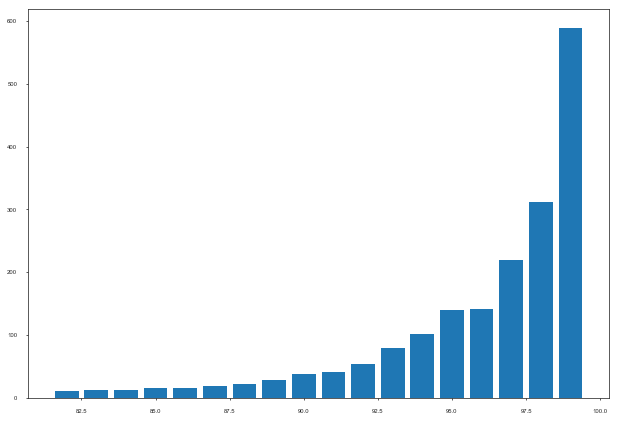

In [440]:
plt.bar(np.arange(100)[-18:], np.sort(np.unique(model_fw.jaccards, return_counts=True)[1])[-18:])

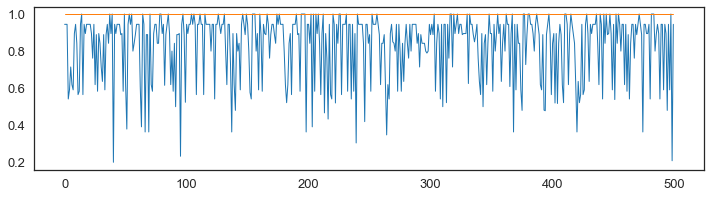

In [11]:
kwargs = {"linewidth": 1}
plt.figure(figsize=(12,3))
plt.plot(model_fw.jaccards[:500], **kwargs)
plt.plot(model_abc.jaccards, **kwargs)

## Model sections

In [ ]:
reload(gp.posterior_analysis)

In [8]:
model = model_fw

In [9]:
# convert centroids to 2d
centroids_2d = []
for centroid in model.centroids:
    centroids_2d.append(gp.topology.convert_centroids_2d(centroid))

In [11]:
# compute models
np.random.seed(9) # 3
iters = np.random.choice(len(model.jaccards), size=3*5)
lbs = []
for i in iters:
    gp.posterior_analysis.change_input_data_general(model.gempy_data[i], interp_data)
    lb, fb = gp.compute_model(interp_data)
    lbs.append(lb)

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


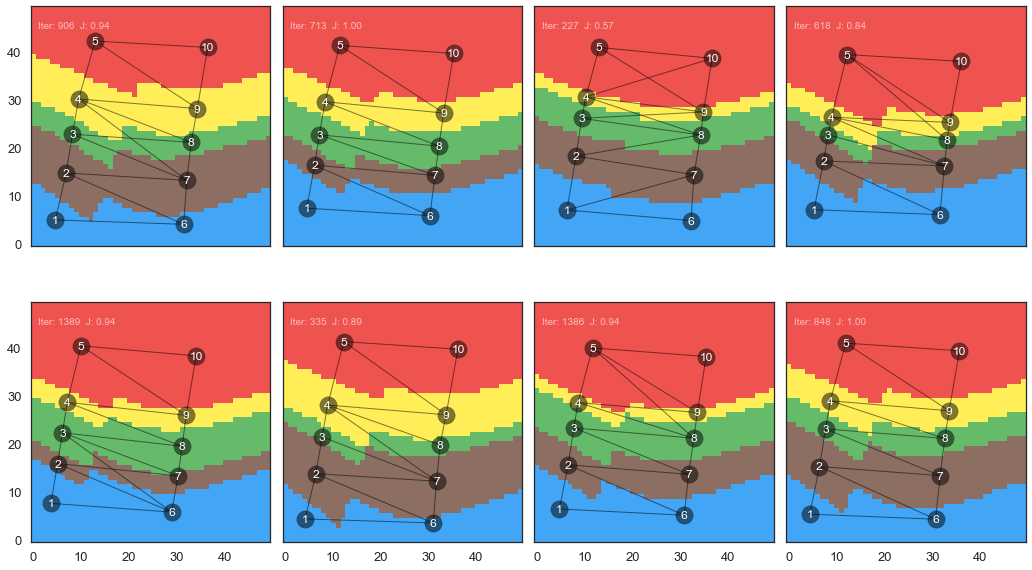

In [12]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=ph.get_figsize(2), sharex=True, sharey=True)
nxkwargs = {"node_color": "black", "alpha": 0.5, "font_color": "white"}

np.random.seed(6) # 10 14
iters = np.random.choice(len(model.jaccards), size=3*5)

for ax, i in zip(axes.flatten(), iters):
    if model.lbs is None:
        gp.posterior_analysis.change_input_data_general(model.gempy_data[i], interp_data)
        lb, fb = gp.compute_model(interp_data)
    else:
        lb = model.lbs[i]
        
    ax.imshow(lb[0].reshape(*geo_data.resolution)[:,12,:].T, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)
    networkx.draw_networkx(model.graphs[i], centroids_2d[i], ax=ax, **nxkwargs)
    
    ax.text(1,45, "Iter: {} ".format(i) + " J: {0:.2f}".format(model.jaccards[i]), color="#ffbcbc")
    
    #ax.set_xlim(0,49)
    #ax.set_ylim(0,49)

plt.tight_layout()

# plt.savefig("test.pdf")

## Entropy

In [12]:
ie_max = np.max([model_fw.ie, model_abc.ie])
ie_min = np.min([model_fw.ie, model_abc.ie])

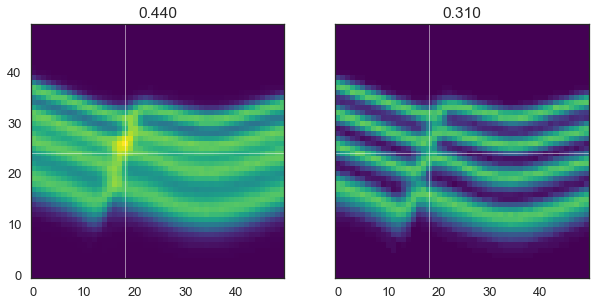

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharey=True)

ax[0].imshow(model_fw.ie.reshape(*geo_data.resolution)[:,24,:].T, origin="lower", cmap="viridis", vmin=ie_min, vmax=ie_max)
ax[0].set_title("{0:.3f}".format(model_fw.iet))
ax[1].imshow(model_abc.ie.reshape(*geo_data.resolution)[:,24,:].T, origin="lower", cmap="viridis", vmin=ie_min, vmax=ie_max)
ax[1].set_title("{0:.3f}".format(model_abc.iet));

for i in range(2):
    ax[i].axvline(18, color="white", linewidth=1, alpha=0.5)
    ax[i].axhline(24, color="white", linewidth=1, alpha=0.5)

In [447]:
0.31/0.44

0.7045454545454546

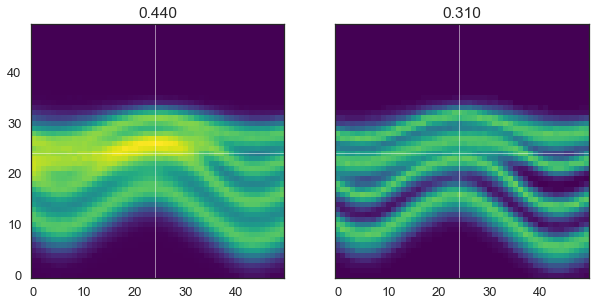

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharey=True)

ax[0].imshow(model_fw.ie.reshape(*geo_data.resolution)[18,:,:].T, origin="lower", cmap="viridis", vmin=ie_min, vmax=ie_max)
ax[0].set_title("{0:.3f}".format(model_fw.iet))
ax[1].imshow(model_abc.ie.reshape(*geo_data.resolution)[18,:,:].T, origin="lower", cmap="viridis", vmin=ie_min, vmax=ie_max)
ax[1].set_title("{0:.3f}".format(model_abc.iet));

for i in range(2):
    ax[i].axvline(24, color="white", linewidth=1, alpha=0.5)
    ax[i].axhline(24, color="white", linewidth=1, alpha=0.5)

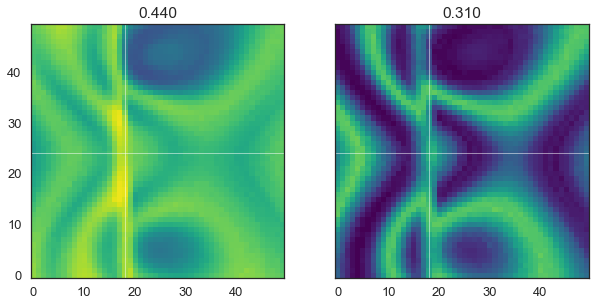

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharey=True)

ax[0].imshow(model_fw.ie.reshape(*geo_data.resolution)[:,:,24].T, origin="lower", cmap="viridis", vmin=ie_min, vmax=ie_max)
ax[0].set_title("{0:.3f}".format(model_fw.iet))
ax[1].imshow(model_abc.ie.reshape(*geo_data.resolution)[:,:,24].T, origin="lower", cmap="viridis", vmin=ie_min, vmax=ie_max)
ax[1].set_title("{0:.3f}".format(model_abc.iet));

for i in range(2):
    ax[i].axvline(18, color="white", linewidth=1, alpha=0.5)
    ax[i].axhline(24, color="white", linewidth=1, alpha=0.5)

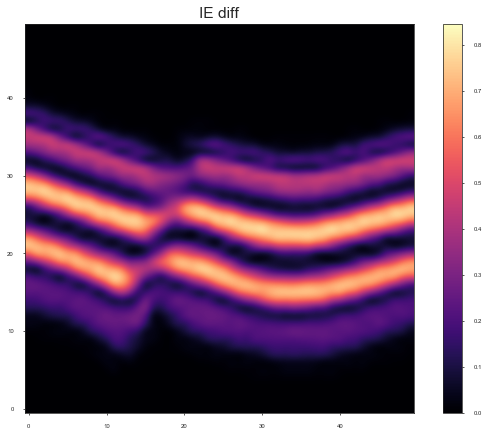

In [449]:
a = np.sqrt(np.square(model_fw.ie.reshape(*geo_data.resolution)[:,24,:] - model_abc.ie.reshape(*geo_data.resolution)[:,24,:]))
im = plt.imshow(a.T, origin="lower", cmap="magma", interpolation="bicubic")
plt.colorbar(im)
plt.title("IE diff")
plt.savefig("../../paper/figures/exp1_ie_diff.pdf", bbox_inches='tight')

In [407]:
from mpl_toolkits.axes_grid1 import ImageGrid
from importlib import reload
from matplotlib import rcParams
reload(ph)
rcParams.update(ph.params)

In [110]:
ie_fw = np.load("data/ie_fw.npy")
iet_fw = np.load("data/iet_fw.npy")
ie_abc = np.load("data/ie_abc.npy")
iet_abc = np.load("data/iet_abc.npy")

In [116]:
for ax in grid:
    print(ax)

LocatableAxes(0.125,0.442744;0.358732x0.199295)
LocatableAxes(0.51241,0.442744;0.358732x0.199295)
LocatableAxes(0.899821,0.442744;0.000179366x0.199295)
LocatableAxes(0.125,0.426712;0.358732x9.96477e-05)
LocatableAxes(0.51241,0.426712;0.358732x9.96477e-05)
LocatableAxes(0.899821,0.426712;0.000179366x9.96477e-05)


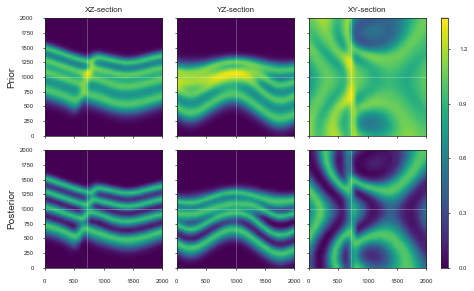

In [204]:
fig = plt.figure(figsize=ph.get_figsize(1, ratio=2))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0.2,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.2)

ies = [model_fw.ie, model_abc.ie]
labels = ["Prior (MCFS)", "Posterior (ABC-REJ)"]

for i, ie, label, iet in zip([0,1], ies, labels, [iet_fw, iet_abc]):
    
    im = grid[0+i*3].imshow(ie.reshape(*geo_data.resolution)[:, 24, :].T, origin="lower", cmap="viridis", vmin=ie_min,
                      vmax=ie_max, interpolation="bicubic", extent=[0,2000,0,2000])
    grid[0+i*3].axvline(18*40, color="white", linewidth=0.5, alpha=0.5)
    grid[0+i*3].axhline(25*40, color="white", linewidth=0.5, alpha=0.5)
    
    im = grid[1+i*3].imshow(ie.reshape(*geo_data.resolution)[18, :, :].T, origin="lower", cmap="viridis", vmin=ie_min,
                      vmax=ie_max, interpolation="bicubic", extent=[0,2000,0,2000])
    
    grid[1+i*3].axvline(25*40, color="white", linewidth=0.5, alpha=0.5)
    grid[1+i*3].axhline(25*40, color="white", linewidth=0.5, alpha=0.5)
    
    im = grid[2+i*3].imshow(ie.reshape(*geo_data.resolution)[:, :, 24].T, origin="lower", cmap="viridis", vmin=ie_min,
                      vmax=ie_max, interpolation="bicubic", extent=[0,2000,0,2000])
    
    grid[2+i*3].axvline(18*40, color="white", linewidth=0.5, alpha=0.5)
    grid[2+i*3].axhline(25*40, color="white", linewidth=0.5, alpha=0.5)
    
    ax.text(1000, 1850, label, fontsize=6, color="white", horizontalalignment='center')
    ax.text(1000, 1750, "Mean IE: {0:.2f}".format(iet), fontsize=5, color="white", horizontalalignment='center')
    #ax.set_title(label, fontsize=8, x=0.5 ,y=0.85, color="white")

grid[0].set_ylabel("Prior", fontsize=10)
grid[3].set_ylabel("Posterior", fontsize=10)
# grid[3].set_ylabel("z")
# grid[3].set_xlabel("x")

# grid[4].set_xlabel("y")

# grid[5].set_xlabel("x")
# grid[5].set_ylabel("y")

for i,title in zip(range(3), ["XZ", "YZ", "XY"]):
    grid[i].set_title(title+"-section", fontsize=8)

cbar = grid[-1].cax.colorbar(im)

cbar.ax.set_xlabel('Information Entropy', fontsize=8)
ax.cax.toggle_label(True)
#plt.tight_layout(rect=[0,0.05,1,1])
# grid[1].set_title("Information Entropy slices of model ensembles", fontsize=9)

plt.savefig("../../paper/figures/exp1_ie2.pdf", bbox_inches='tight')

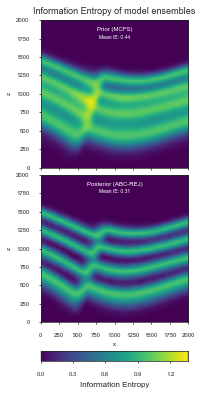

In [185]:
fig = plt.figure(figsize=ph.get_figsize(1, textwidth=252, ratio=1.8))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 1),
                 axes_pad=0.1,
                 cbar_location="bottom",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3)

ies = [model_fw.ie, model_abc.ie]
labels = ["Prior (MCFS)", "Posterior (ABC-REJ)"]

for ax, ie, label, iet in zip(grid, ies, labels, [iet_fw, iet_abc]):
    im = ax.imshow(ie.reshape(*geo_data.resolution)[:, 12, :].T, origin="lower", cmap="viridis", vmin=ie_min,
                      vmax=ie_max, interpolation="bicubic", extent=[0,2000,0,2000])
    ax.text(1000, 1850, label, fontsize=6, color="white", horizontalalignment='center')
    ax.text(1000, 1750, "Mean IE: {0:.2f}".format(iet), fontsize=5, color="white", horizontalalignment='center')
    #ax.set_title(label, fontsize=8, x=0.5 ,y=0.85, color="white")
    ax.set_ylabel("z")

grid[1].set_xlabel("x")



cbar = ax.cax.colorbar(im)
cbar.ax.set_xlabel('Information Entropy', rotation=0, fontsize=8)
ax.cax.toggle_label(True)
#plt.tight_layout(rect=[0,0.05,1,1])
grid[0].set_title("Information Entropy of model ensembles", fontsize=9)

plt.savefig("../../paper/figures/exp1_ie.pdf", bbox_inches='tight')

## Fault Orientation

In [33]:
import mplstereonet
def plot(models):
    
    fig, ax = mplstereonet.subplots(ncols=2, figsize=(10,5))
    
    for i, model in enumerate(models):
#         for strike, dip in zip(model.azs+90, model.dips):
#             ax[i].pole(strike, dip, alpha=0.3, marker=".")

        ax[i].density_contourf(model.azs[:, 0]+90, model.dips[:, 0], measurement='poles', cmap="viridis")

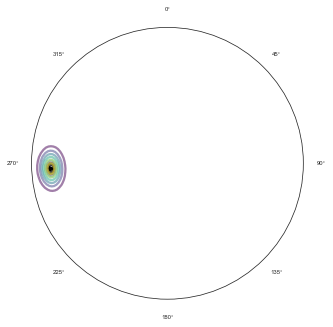

In [99]:
fig, ax = mplstereonet.subplots(ncols=1, figsize=(10,5))
    
ax.density_contour(model_fw.azs[:, 0]+90, model_fw.dips[:, 0], measurement='poles', cmap="Greys", alpha=1)
ax.density_contour(model_abc.azs[:, 0]+90, model_abc.dips[:, 0], measurement='poles', cmap="viridis", alpha=0.5)

## Posteriors

Input:

* List of traces (data)
* List of names
* (Overall Name)

In [30]:
ph.get_figsize(1)

[7.222914072229141, 4.464006394457523]

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


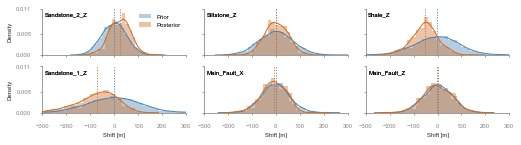

In [105]:
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7.2229, 2), sharey=True, sharex=True)

kde_kws = {"linewidth": 1}
hist_kws = {"histtype": "stepfilled"}


for model, label, color in zip([model_fw, model_abc], ["Prior", "Posterior"], ["steelblue", "chocolate"]):
    for ax, t in zip(axes.flatten(), model.traces.items()):
        
        sns.distplot(t[1] * interp_data.rescaling_factor, ax=ax, label=label, kde_kws=kde_kws, hist_kws=hist_kws, color=color)
            
        ax.text(-290, 0.0093, t[0], fontsize=6, horizontalalignment="left", alpha=1, color="black")
        ax.axvline(np.mean(t[1] * interp_data.rescaling_factor), linewidth=1, color=color, linestyle="dotted")
        ax.set_ylim(0, 0.011)
        ax.set_yticks([0, 0.005, 0.011])
        ax.set_xlim(-300,300)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        #ax.spines['left'].set_visible(False)
        
        ax.tick_params(color='grey', labelcolor='grey')
        for spine in ax.spines.values():
            spine.set_edgecolor('grey')

l = axes.flatten()[0].legend(fontsize=6)
for text in l.get_texts():
    text.set_color("black")

axes[1,0].set_xlabel("Shift [m]")
axes[1,1].set_xlabel("Shift [m]")
axes[1,2].set_xlabel("Shift [m]")
for i in range(2):
    axes[i,0].set_ylabel("Density")
plt.tight_layout()

plt.savefig("../../paper/figures/exp1_distplot.pdf", bbox_inches='tight')

In [87]:
p = np.array([trace for trace in model_fw.traces.values()])
n = [tn for tn in model_fw.traces.keys()]

In [97]:
p_abc = np.array([trace for trace in model_abc.traces.values()])
n_abc = [tn for tn in model_abc.traces.keys()]

In [98]:
import pandas as pd
df = pd.DataFrame(p.T, columns=n)
df_abc = pd.DataFrame(p_abc.T, columns=n_abc)

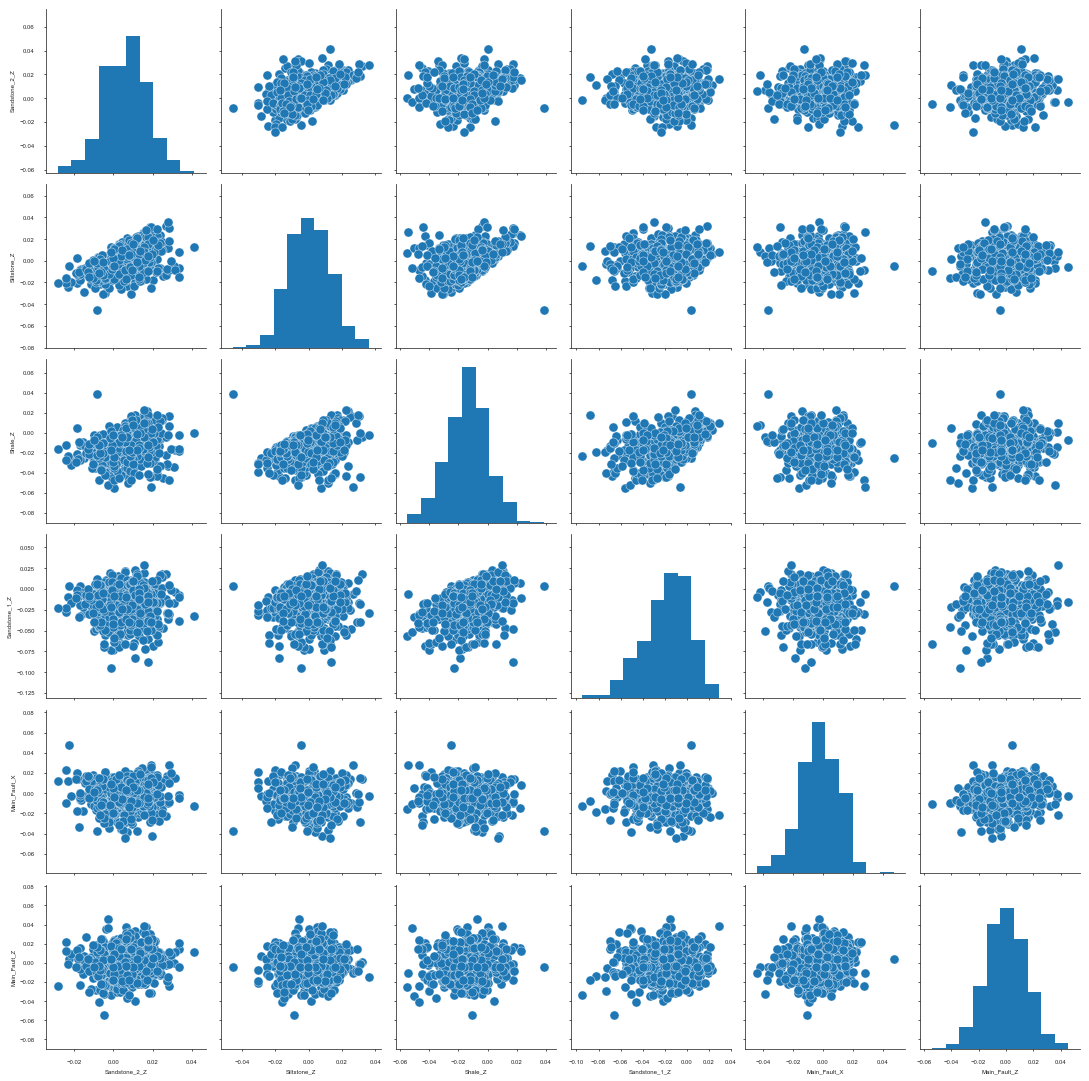

In [101]:
sns.pairplot(df_abc, kind="")

### Stat analysis

In [454]:
from scipy.stats import describe

In [461]:
describe(model_fw.traces["Sandstone_1_Z"] * interp_data.rescaling_factor)

DescribeResult(nobs=2000, minmax=(-386.6919673423136, 373.5598675580624), mean=-0.19242675782814764, variance=12019.682827545019, skewness=-0.001474968495039839, kurtosis=0.11362237994808977)

In [460]:
describe(model_abc.traces["Sandstone_1_Z"] * interp_data.rescaling_factor)

DescribeResult(nobs=500, minmax=(-369.24912231049547, 112.51245544488974), mean=-72.07611615154103, variance=6717.252088430421, skewness=-0.6111467604065938, kurtosis=0.17409052830073657)

In [462]:
describe(model_fw.traces["Shale_Z"] * interp_data.rescaling_factor)

DescribeResult(nobs=2000, minmax=(-325.890672252513, 303.1793912495256), mean=-2.258642503963175, variance=8209.246715319341, skewness=-0.07126536258574616, kurtosis=0.17270647176672016)

In [463]:
describe(model_abc.traces["Shale_Z"] * interp_data.rescaling_factor)

DescribeResult(nobs=500, minmax=(-213.42471358294796, 150.15810729596606), mean=-52.698869879996565, variance=3008.52352255733, skewness=-0.07883509252416178, kurtosis=0.3085608802179638)

In [465]:
describe(model_fw.traces["Siltstone_Z"] * interp_data.rescaling_factor)

DescribeResult(nobs=2000, minmax=(-205.2800465170649, 277.7298366537819), mean=1.077373541523466, variance=4903.0192650849685, skewness=0.05952469876937449, kurtosis=-0.03338510502657144)

In [464]:
describe(model_abc.traces["Siltstone_Z"] * interp_data.rescaling_factor)

DescribeResult(nobs=500, minmax=(-177.3709823210383, 140.8187972559323), mean=2.2202218191962984, variance=2262.902553907918, skewness=-0.03075168629968575, kurtosis=-0.018896352472808964)

In [469]:
1 - np.sqrt(3008)/np.sqrt(8209)

0.3946677835965935

In [468]:
1 - np.sqrt(2262)/np.sqrt(4903)

0.3207723549803623

## Traces

In [33]:
def plot_traces(model, axes=None):
    if axes is None:
        fig, axes = plt.subplots(nrows=len(model.traces.keys()))
    for ax, t in zip(axes, model.traces.items()):
        ax.plot(t[1] * interp_data.rescaling_factor, linewidth=0.5)
        ax.axhline(np.mean(t[1])* interp_data.rescaling_factor)
        ax.set_title(t[0])

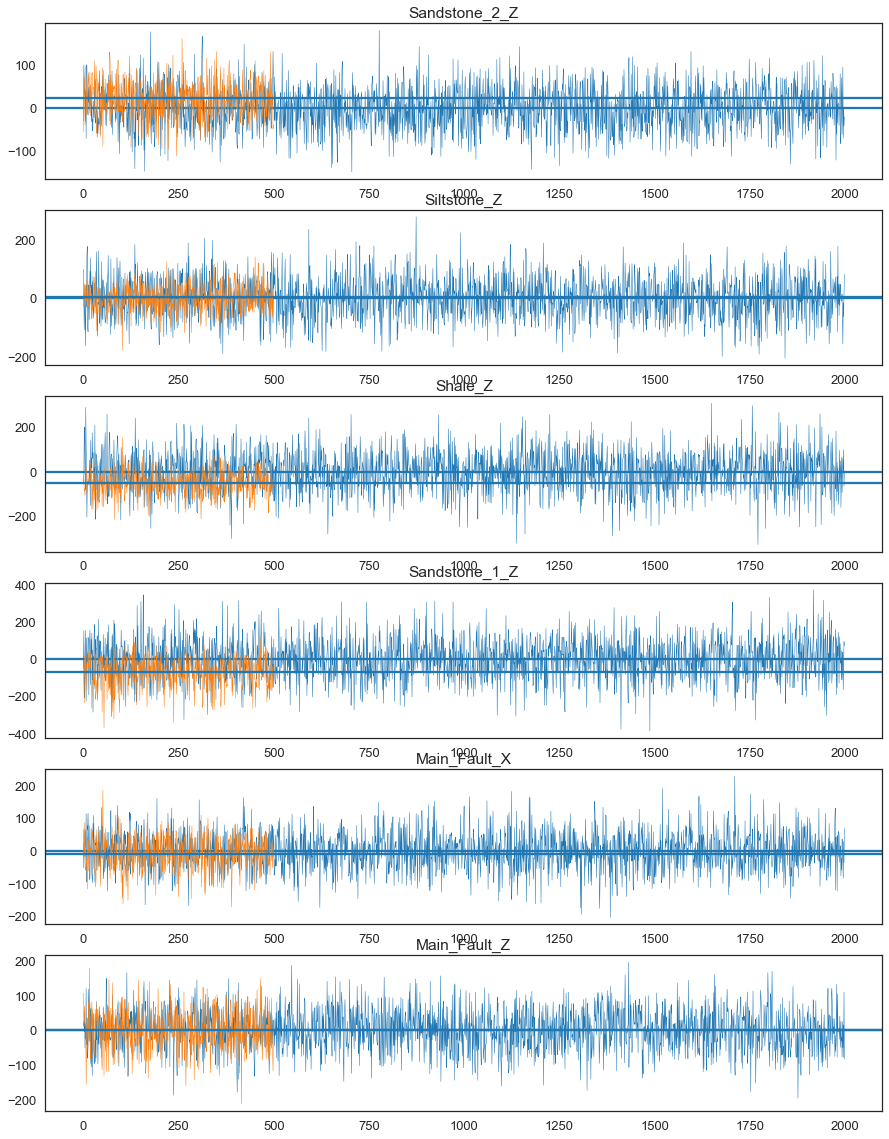

In [36]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15,4*5))

plot_traces(model_fw, axes=axes)
plot_traces(model_abc, axes=axes)

## Prior parametrization

In [206]:
gp.plot_section?

6.8999999999999995

In [404]:
500 * 1./ model_abc.acc_ratio

3450.0

array([ 900.,  900.,  900.,  900.,    0.,  300.,  600., 1100., 1400.,
       1700., 1500.,  900., 1500.])

In [241]:
for prior in model_fw.priors:
    print(prior.name[:-2])

Sandstone_2
Siltstone
Shale
Sandstone_1
Main_Fault
Main_Fault


C:/Users/r02as18/git/gempy\gempy\gempy_front.py:956: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


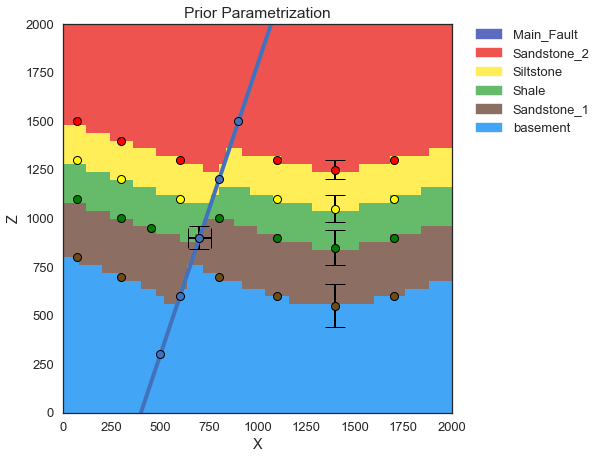

In [400]:
#fig, axes = plt.subplots(nrows=1, ncols=1, , sharey=True, sharex=True)

gp.plot_section(geo_data, lb_init[0], 24)


plt.plot(np.array([330,1000])+70,[0,2000], linewidth=4, color="#4372bc")

for prior, color in zip(model_fw.priors, ["red", "yellow", "green", "#6d4c1a", "#4372bc", "#4372bc"]):
    f1 = geo_data.interfaces["formation"] == prior.name[:-2]
    f2 = geo_data.interfaces["Y"] == 1000.
    f = f1 & f2
    X = geo_data.interfaces[f].X.values
    Z = geo_data.interfaces[f].Z.values
    
    for x,z in zip(X,Z):
        if prior.column == "Z":
            if x == 0: 
                x =+ 70
                y -= 20
            plt.plot(x,z,"o", markersize=8, color=color, markeredgewidth=1, markeredgecolor="black")
            if x > 1250 and x < 1500 or x > 650 and x < 750:
                (_, caps, _) = plt.errorbar(x,z, yerr=prior.std(), color="black", linewidth=2, alpha=1)
                for cap in caps:
                    cap.set_markeredgewidth(1)
                    cap.linewidth = 1
        elif prior.column == "X":
            if x > 1250 and x < 1500 or x > 650 and x < 750:
                (_, caps, _) = plt.errorbar(x,z, xerr=prior.std(), color="black", linewidth=2, alpha=1)
                for cap in caps:
                    cap.set_markeredgewidth(1)
                    cap.linewidth = 1

# plt.quiver(750,1000,mu[0],mu[2])
plt.title("Prior Parametrization")
plt.savefig("../../paper/figures/exp1_parametrization.pdf", bbox_inches='tight')

In [401]:
model_abc.acc_ratio

0.14492753623188406

In [394]:
geo_data.orientations.iloc[0]["formation"]

'Main_Fault'

In [349]:
ver, sim = gp.get_surfaces(interp_data, potential_lith=lb_init[1], potential_fault=fb_init[1])

In [354]:
gp.plot_surfaces_3D(geo_data, ver, sim)

C:/Users/r02as18/git/gempy\gempy\gempy_front.py:902: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


closing vtk


In [353]:
gp.export_to_vtk(geo_data, path="vtk_export", lith_block=lb_init[0], vertices=ver, simplices=sim)

C:/Users/r02as18/git/gempy\gempy\gempy_front.py:873: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


## Topo Init

In [368]:
G, C, *_, rprops = gp.topology_compute(geo_data, lb_init[0], fb_init, filter_rogue=True, return_rprops=True, filter_threshold_area=20)

In [369]:
C2d = gp.topology.convert_centroids_2d(C)

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


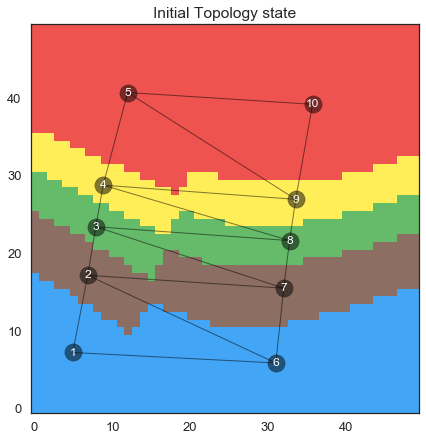

In [379]:
fig, ax = plt.subplots()
nxkwargs = {"node_color": "black", "alpha": 0.5, "font_color": "white"}
ax.imshow(lb_init[0].reshape(*geo_data.resolution)[:,12,:].T, origin="lower", 
          cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)
networkx.draw_networkx(G, C2d, ax=ax, **nxkwargs)

plt.title("Initial Topology state")
plt.savefig("../../paper/figures/exp1_init_topo.pdf", bbox_inches='tight')